## **Imports and notebook configs**


In [112]:
'''Imports'''

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import TransformedTargetRegressor
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline



## Dataset Observation and Properties

Lets load our data into dataframes and observe the first few rows

In [113]:
'''load datasets'''

train_df = pd.read_csv('Datasets/SE_rents2018_train.csv')   
test_df = pd.read_csv('Datasets/SE_rents2018_test1.csv')
schools_df = pd.read_csv('Datasets/best_schools_neigh.csv')

In [114]:
train_df.head()

,rental_id,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,...,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line
0,7236931,#22A,551248,4,3.0,1300.0,2018-06-04 16:31:06,645 OCEAN AVENUE,Brooklyn,11226,...,0,0,3925,1,MAGNIFICENT GUT RENOVATED 4 BEDROOM 3 BATHROOM...,Flatbush,Brooklyn,22A,NaN,NaN
1,7331920,#406,3373,0,1.0,475.0,2018-07-03 20:11:43,93 WORTH STREET,New York,10013,...,0,0,3350,0,Want to live in the hottest neighborhood in to...,Tribeca,Manhattan,406,4.0,06
2,7139224,#18A,70747,3,3.0,1886.0,2018-05-02 16:10:27,305 EAST 51 STREET,New York,10022,...,1,0,11500,0,"High floor totally renovated 3 bedrooms, 3 bat...",Midtown East,Manhattan,18A,18.0,A
3,7364827,#23E,42076,1,1.0,827.0,2018-07-13 16:06:55,70 WEST 37TH STREET,New York,10018,...,0,0,3772,1,**SHORT TERM LEASES AVAILABLE**\n\n****Photogr...,Midtown South,Manhattan,23E,23.0,E
4,7242151,#3B,319156,3,1.0,1200.0,2018-06-05 16:35:40,43 MAC DONOUGH STREET,Brooklyn,11216,...,0,0,2595,1,This is a Huuge 3 bedroom apt. located in a pr...,Bedford-Stuyvesant,Brooklyn,3B,3.0,B


In [115]:
test_df.head()

,rental_id,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,...,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line
0,7499437,#1B,18724,1,1.0,550.0,2018-08-22 10:00:37,167 MOTT STREET,New York,10013,...,0,0,2700,1,"By Owner, No Fees!\n\nNewly renovated building...",Little Italy,Manhattan,1B,1.0,B
1,7477903,#C4,403900,1,1.0,750.0,2018-08-15 11:41:23,107 LINDEN STREET,Brooklyn,11221,...,0,0,1650,1,this is a beautiful spacious renovated full s...,Bushwick,Brooklyn,C4,4.0,C
2,7481023,#GARDEN,18175264,2,1.0,800.0,2018-08-15 22:20:14,47 CARROLL STREET,Brooklyn,11231,...,1,0,2900,0,"Garden level, pet-friendly, 2 bedroom, 1 bath ...",Columbia St Waterfront District,Brooklyn,GARDEN,NaN,NaN
3,7479547,#2C,104863,2,2.0,1300.0,2018-08-15 16:05:22,952 COLUMBUS AVENUE,New York,10025,...,0,0,4750,1,Ivy Park is a boutique condominium with a uniq...,Upper West Side,Manhattan,2C,2.0,C
4,7518814,#9,95125,2,1.0,750.0,2018-08-29 12:00:12,424 EAST 116 STREET,New York,10029,...,0,0,1800,0,Located across from the New East River Plaza w...,East Harlem,Manhattan,9,NaN,NaN


Let's look at all the column names in a list

In [116]:
print(f"Train Data Columns:{list(train_df)}\n")
print(f"Test Data Columns:{list(test_df)}\n")

Train Data Columns:['rental_id', 'addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat', 'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway', 'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher', 'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden', 'has_childrens_playroom', 'rent', 'no_fee', 'description', 'neighborhood', 'borough', 'unit', 'floornumber', 'line']

Test Data Columns:['rental_id', 'addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat', 'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway', 'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher', 'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden', 'has_ch

## Data Cleaning

- Method: Dropping unecessary columns from datasets and save id information

we are dropping these columns because they will not be needed in the modelling as they are identification columns.

In [117]:
print(f"Train Data Shape Before Drop:{train_df.shape}")
print(f"Test Data Shape Before Drop:{test_df.shape}\n")

# save id columns
train_id = train_df['rental_id']
test_id = test_df['rental_id']

#drop unnecessary columns

train_df.drop(["rental_id","created_at",'description','bin'],axis=1,inplace=True)
test_df.drop(["rental_id","created_at",'description','bin'],axis=1,inplace=True)

print(f"Train Data Shape After Drop: {train_df.shape}")
print(f"Test Data Shape After Drop: {test_df.shape}")

Train Data Shape Before Drop:(12000, 39)
Test Data Shape Before Drop:(2000, 39)

Train Data Shape After Drop: (12000, 35)
Test Data Shape After Drop: (2000, 35)


## Data Visualization

- Visualizing properties of target 'rent' variable

In [118]:
# Target Variable Description: 'rent'

train_df['rent'].describe()

count    12000.000000
mean      3605.762917
std       2897.069446
min       1250.000000
25%       2250.000000
50%       2900.000000
75%       3900.000000
max      50000.000000
Name: rent, dtype: float64

**Observations**

- We can see that the mean rent is about 3600 
- The standard deviation is about 2900
- The Min rent is 1250
- The Max rent is 50000

This tells us that the range of rent has a high variation and we need to investigate why when we model in the future.

Lets visualize these stats for better understanding...

mu: 3605.76
sigma:2.9e+03


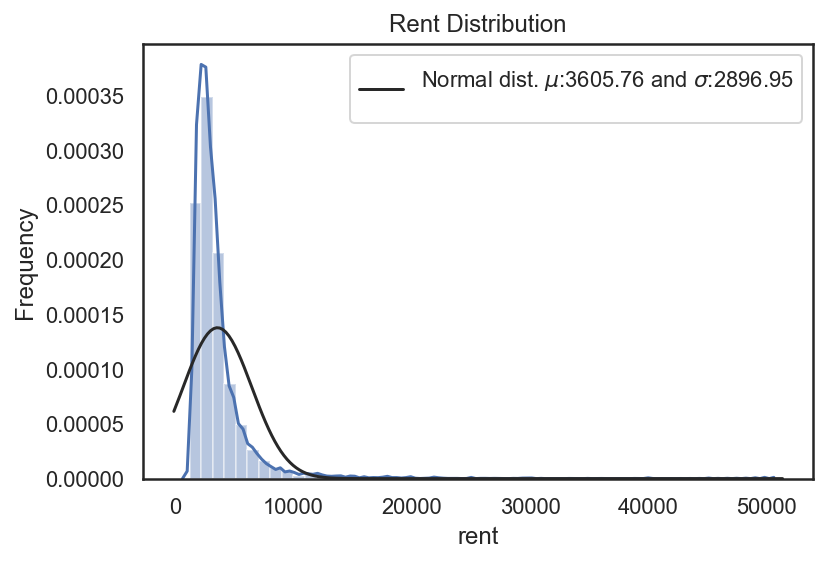

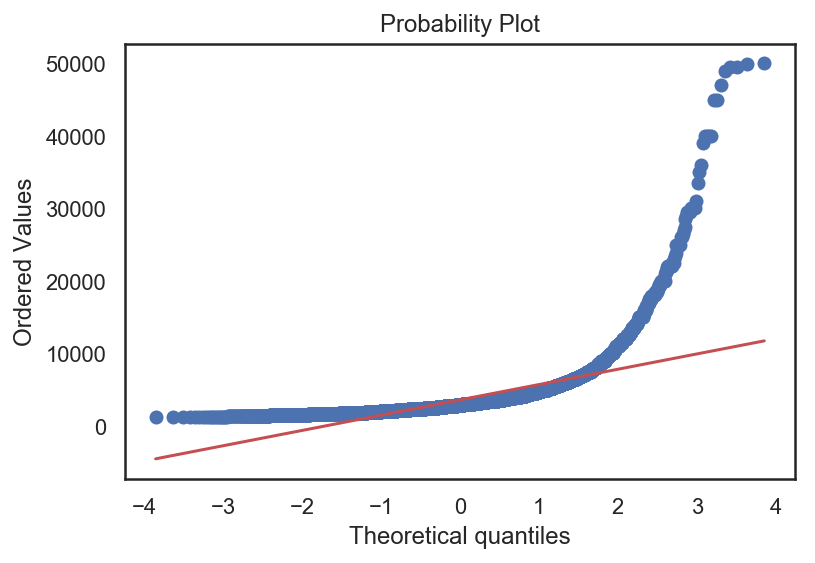

Skewness:6.282718976779915
Kurtosis:64.84190569996547


In [119]:
# Visualize Target Variable

sns.distplot(train_df['rent'], fit=norm)

(mu,sigma)= norm.fit(train_df['rent'])

print(f"mu: {mu:.2f}\nsigma:{sigma:.2}")

plt.legend([f'Normal dist. $\mu$:{mu:.2f} and $\sigma$:{sigma:.2f}\n'],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rent Distribution')

fig = plt.figure()
res = stats.probplot(train_df['rent'], plot=plt)
plt.show()

print(f"Skewness:{train_df['rent'].skew()}")
print(f"Kurtosis:{train_df['rent'].kurt()}")

### Observations from Target Variable

- Skewness suggest:
    - Lack of symmetry in rent distribution
    - Mean and median are greater than the mode

- Kurtosis suggest:
    - Heavy tails in distribution
    - Lots of outliers in data

## Visualization of Features Against Rent

- Dividing categorical and numerical datatypes in dataframe

In [120]:
# Categorical Data
train_df.select_dtypes(include=['object']).columns

Index(['addr_unit', 'addr_street', 'addr_city', 'neighborhood', 'borough',
       'unit', 'line'],
      dtype='object')

In [121]:
# Numiercal Data 
train_df.select_dtypes(include=['int64','float64']).columns

Index(['building_id', 'bedrooms', 'bathrooms', 'size_sqft', 'addr_zip',
       'addr_lat', 'addr_lon', 'bbl', 'floor_count', 'year_built',
       'min_to_subway', 'has_doorman', 'has_elevator', 'has_fireplace',
       'has_dishwasher', 'is_furnished', 'has_gym', 'allows_pets',
       'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge',
       'has_pool', 'has_garden', 'has_childrens_playroom', 'rent', 'no_fee',
       'floornumber'],
      dtype='object')

In [122]:
num_categorical = len(train_df.select_dtypes(include=['object']).columns)
num_numerical = len(train_df.select_dtypes(include=['int64','float64']).columns)
print(f"Categorical Features:{num_categorical}\nNumerical Features:{num_numerical}")
print(f"Total Features:{num_categorical+num_numerical}")


Categorical Features:7
Numerical Features:28
Total Features:35


We have mostly numerical features and a couple categorical features... we will need to encode some of the most useful categorical features like neighborhoodand borough...

## Narrowing Down Optimal Features

- Lets look at which features would be most important in predicting rent 

- Creating a correlations matrix we can observe relationships

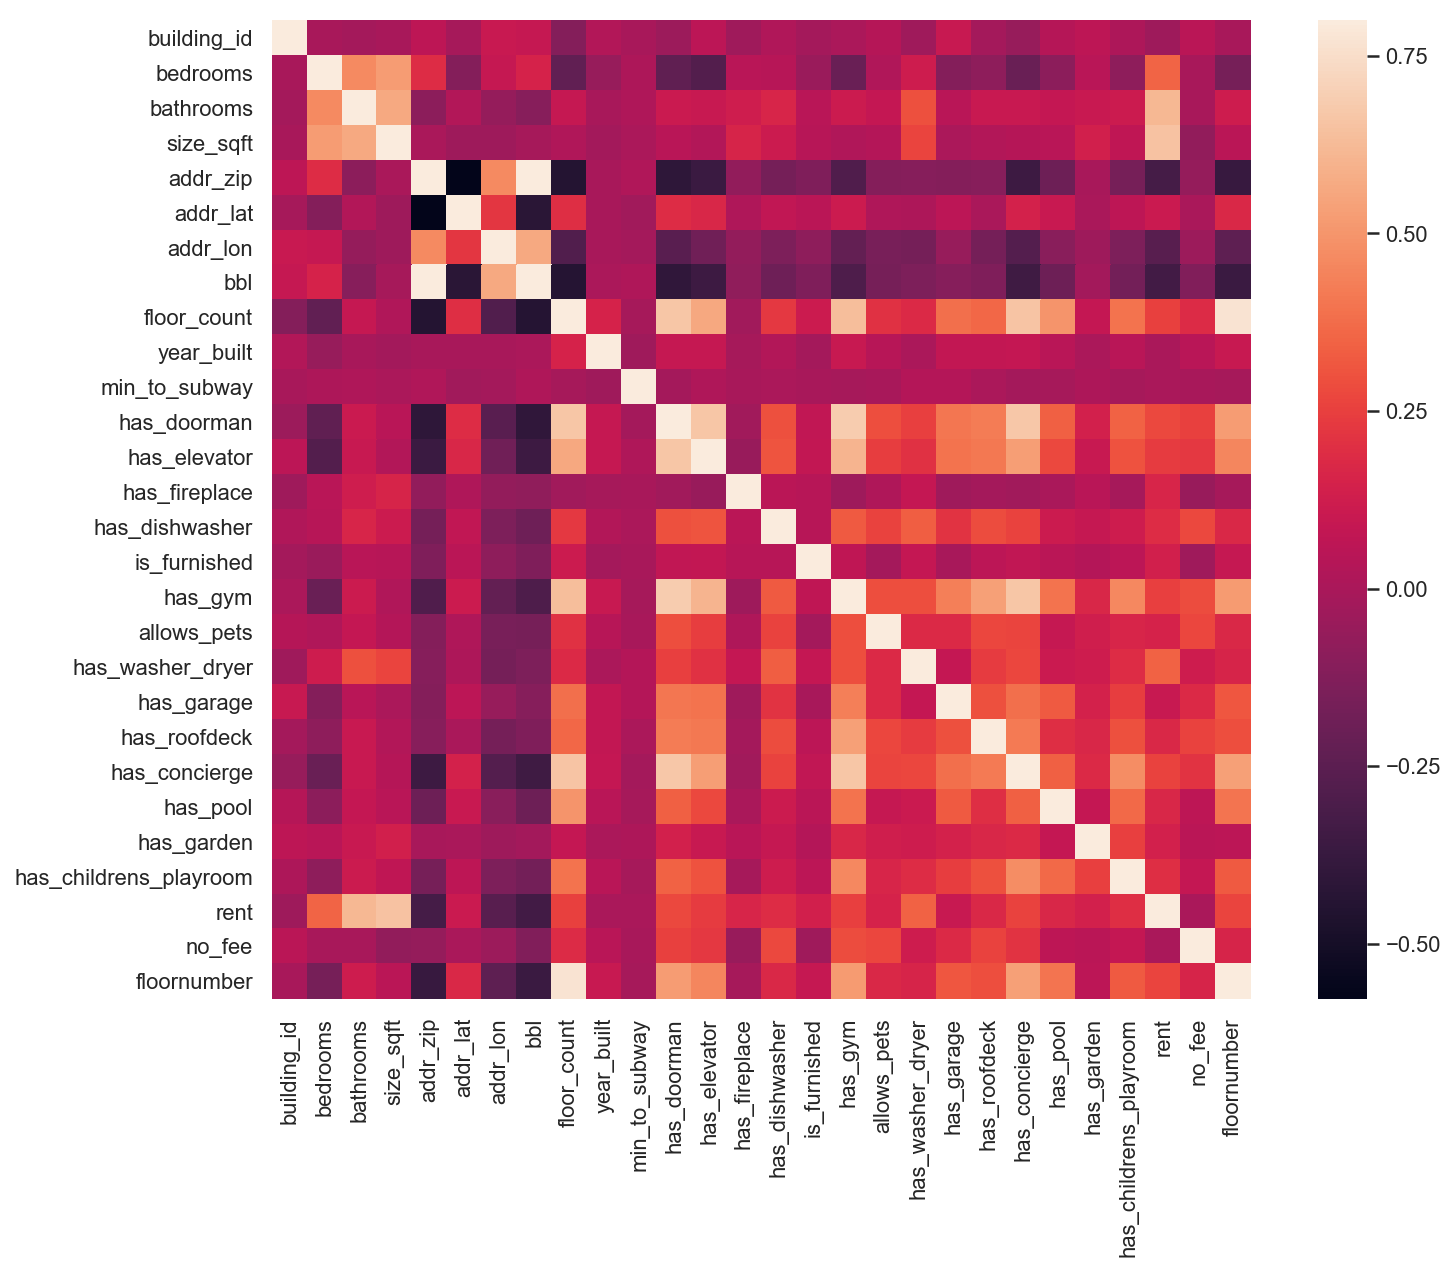

In [123]:
# Correlation Matrix Heatmap

corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

**Lots of features above, lets try an narrow the relationships down to the top 10.**

Index(['rent', 'size_sqft', 'bathrooms', 'bedrooms', 'has_washer_dryer',
       'has_doorman', 'floornumber', 'has_concierge', 'floor_count', 'has_gym',
       'has_elevator', 'has_childrens_playroom', 'has_dishwasher',
       'has_roofdeck', 'has_pool', 'has_fireplace'],
      dtype='object')


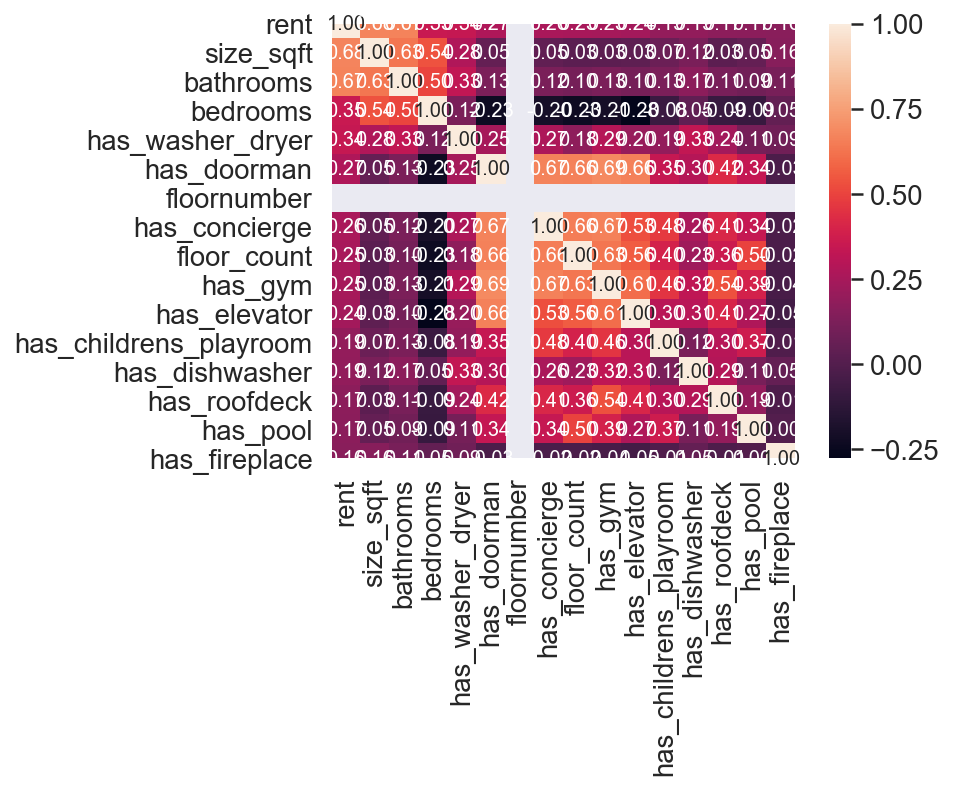

In [ ]:
# Top k Heatmap

k = 16 #number of variables for heatmap
cols = corrmat.nlargest(k, 'rent')['rent'].index
print(cols)
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Lets order them by most correlated to least for better understanding**

In [ ]:
most_corr = pd.DataFrame(cols[1::])
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,size_sqft
1,bathrooms
2,bedrooms
3,has_washer_dryer
4,has_doorman
5,floornumber
6,has_concierge
7,floor_count
8,has_gym
9,has_elevator


## Visualizing Features with Respect to Target

- After observing the 10 most correlated features we can plot them to visualize how they interact better
- This will also give us intuition about outliers and any wierd anomalies in the data

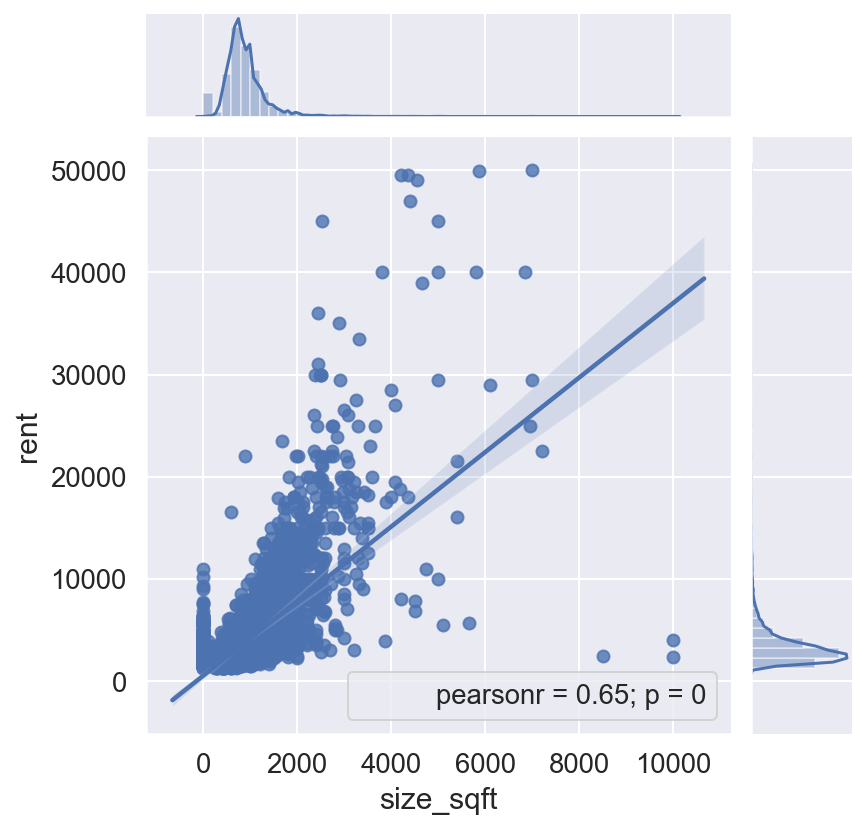

In [126]:
# # size_sqft vs rent

# sns.jointplot(x=train_df['size_sqft'], y=train_df['rent'], kind='reg').annotate(stats.pearsonr)



**Observations**

- `size_sqft` seems to be positively correlated with `rent` 
- Outliers exist for `size_sqft` > 8000
- Potential issues with `size_sqft` = 0, we will need to impute these
- Let's look at observations greater than 30k as they seem like extreme values

Lets remove the outliers as linear regression models are less accurate with tons of outliers

In [127]:
train_df[train_df['rent']>=30000].sort_values(by='size_sqft')

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,addr_street,addr_city,addr_zip,addr_lat,addr_lon,...,has_pool,has_garden,has_childrens_playroom,rent,no_fee,neighborhood,borough,unit,floornumber,line
7705,#3F,72115,3,3.0,2380.0,21 EAST 61ST STREET,New York,10065,40.765301,-73.970596,...,1,0,0,30000,0,Upper East Side,Manhattan,3F,3.0,F
7947,#7A,72115,3,3.0,2443.0,21 EAST 61ST STREET,New York,10065,40.765301,-73.970596,...,1,0,0,31000,0,Upper East Side,Manhattan,7A,7.0,A
1352,NaN,28957,3,3.0,2448.0,291 WEST 4 STREET,New York,10014,40.736581,-74.003453,...,0,1,0,36000,0,West Village,Manhattan,NaN,NaN,NaN
8726,#32D,68995,3,3.0,2491.0,151 EAST 58 STREET,New York,10022,40.761600,-73.967598,...,0,0,1,30000,0,Midtown East,Manhattan,32D,32.0,D
1330,#48DE,4142872,4,4.0,2500.0,101 WEST 67 STREET,New York,10023,40.774502,-73.981400,...,1,0,0,30000,0,Upper West Side,Manhattan,48DE,48.0,DE
370,#6E,62341,4,4.0,2512.0,100 WEST 80 STREET,New York,10024,40.782539,-73.975377,...,0,0,0,30000,0,Upper West Side,Manhattan,6E,6.0,E
919,#18C,41068,3,3.0,2527.0,10 MADISON SQUARE WEST,New York,10010,40.742699,-73.989601,...,1,0,0,45000,0,Flatiron,Manhattan,18C,18.0,C
4203,#PH,78052,4,4.0,2900.0,301 EAST 61ST STREET,New York,10065,40.761902,-73.963097,...,0,1,0,35000,0,Upper East Side,Manhattan,PH,19.0,NaN
11078,#14D,41068,4,4.0,3309.0,10 MADISON SQUARE WEST,New York,10010,40.742699,-73.989601,...,1,0,1,33500,0,Flatiron,Manhattan,14D,14.0,D
258,#12S,56830,5,5.0,3800.0,135 CENTRAL PARK WEST,New York,10023,40.777344,-73.975538,...,0,0,0,40000,0,Upper West Side,Manhattan,12S,12.0,S


Although the values above are extreme, they make 'sense' in that prominent features when looking at the price of an apartment like size, rooms, and bathrooms are fairly good by nyc standards, especially in Manhattan and in their respective neighborhoods. 

We will not remove these 

In [128]:
# Remove outliers

train_df = train_df.drop(train_df[(train_df['size_sqft']>8000) 
                         & (train_df['rent']<10000)].index).reset_index(drop=True)

let's look at the graph again

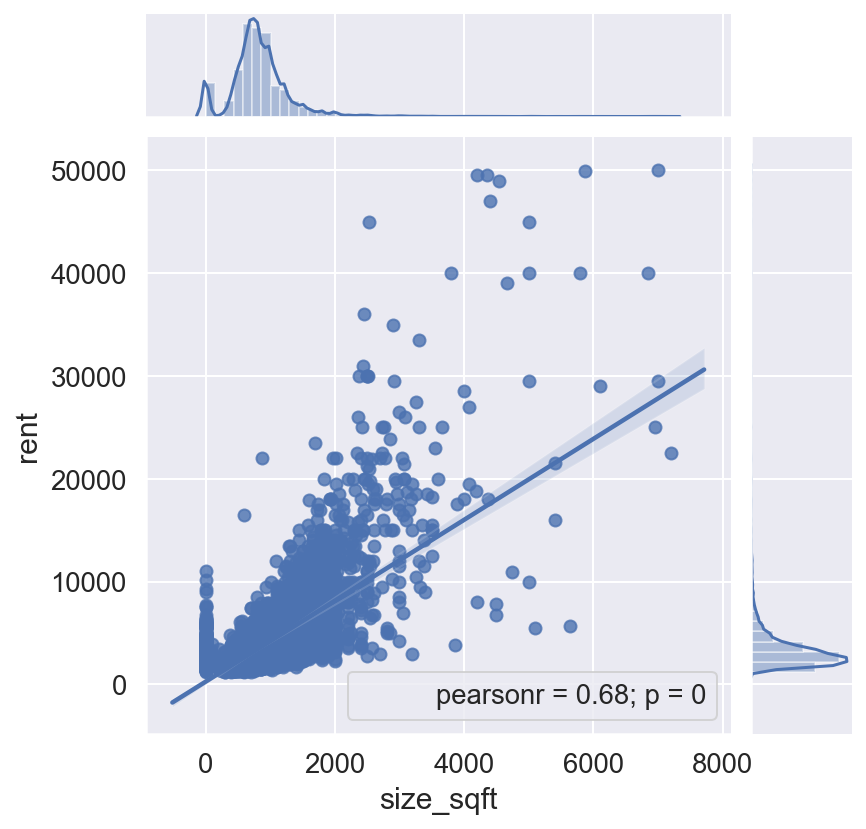

In [129]:
# # size_sqft vs rent

# sns.jointplot(x=train_df['size_sqft'], y=train_df['rent'], kind='reg').annotate(stats.pearsonr)


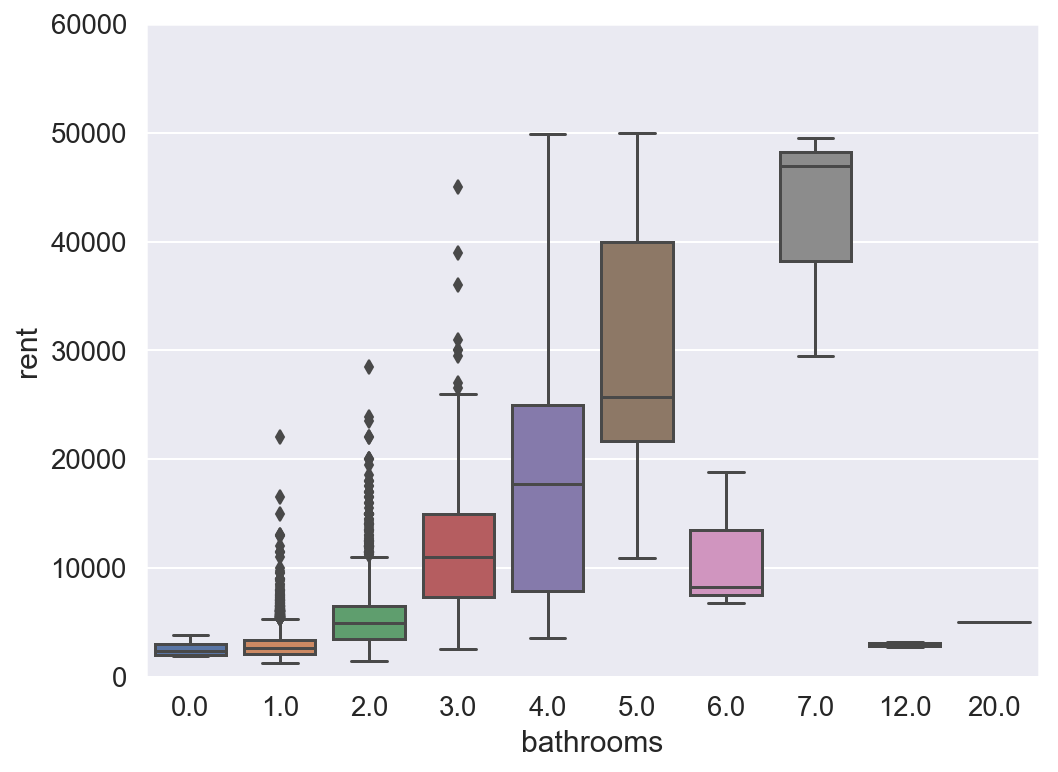

In [ ]:
# bathrooms vs rent
var = 'bathrooms'
data = pd.concat([train_df['rent'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="rent", data=data)
fig.axis(ymin=0, ymax=60000);

**Observations**

- bathrooms seems positively correlated with rent
- there seems to be outliers for bathrooms > 12 and equal to 6
- looks like listing with 0 bathroom are a bit odd, we need to take a closer look


In [ ]:
train_df[train_df['bathrooms']==0]

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,addr_street,addr_city,addr_zip,addr_lat,addr_lon,...,has_pool,has_garden,has_childrens_playroom,rent,no_fee,neighborhood,borough,unit,floornumber,line
171,NaN,503473,2,0.0,0.0,319 EAST 52 STREET,Brooklyn,11203,40.653066,-73.928286,...,0,0,0,2000,0,East Flatbush,Brooklyn,NaN,NaN,NaN
5456,#3,158941,1,0.0,880.0,496 COURT STREET,Brooklyn,11231,40.676940,-73.998828,...,0,0,0,2750,0,Carroll Gardens,Brooklyn,3,3.0,NaN
7224,UNKNOWN,161965,0,0.0,0.0,230 SMITH STREET,Brooklyn,11231,40.683953,-73.992569,...,0,0,0,3799,0,Cobble Hill,Brooklyn,UNKNOWN,NaN,NaN
9527,#1C,25639,0,0.0,0.0,29 WEST 12 STREET,New York,10011,40.735335,-73.995609,...,0,0,0,1900,1,Greenwich Village,Manhattan,1C,1.0,C


After observing these and doing some online digging, we are not going to remove them because 

- some of these do indeed have bathrooms
- others have bathrooms just not in the traditional sense, i.e toilet and sink in seperate rooms or shared bathrooms

In [ ]:
# remove bathroom outliers

train_df = train_df.drop(train_df[(train_df['bathrooms']>=12) 
                         & (train_df['rent']<10000)].index).reset_index(drop=True)

train_df = train_df.drop(train_df[(train_df['bathrooms']==6) 
                         & (train_df['rent']<20000)].index).reset_index(drop=True)

Let's take another look

In [ ]:
# # bathrooms vs rent
# var = 'bathrooms'
# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=60000);

Bathrooms looks a lot better and the values make more sense now

In [ ]:
# # bedrooms vs rent
# var = 'bedrooms'
# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=100000);

**Observations**

-`bedrooms` is postively correlated with rent
- outiers seem present with `bedrooms` = 8
- We might need to remove bedrooms = 6 as it seems like a outlier but we'll leave it for now

we are going to leave everything as is for now.


In [ ]:
# # has_washer_dryer vs rent
# var = 'has_washer_dryer'
# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=100000);

**Observations**

- seems like listings with `washer/dryers` fetch a higher average price

Nothing to be removed here

In [ ]:
# # has_doorman vs rent

# var = 'has_doorman'
# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=100000);

**Observations**

- Again, seems like listings with `has_doorman` fetch higher avg prices.

Nothing to removed here

In [ ]:
# # floornumber vs rent

# var = 'floornumber'
# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(15, 15))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=60000);

**Observations** 

- Suggest higher `floornumbers` fetch slightly higher prices
- there seems to be a steady correlation as you increase floornumber
- floornumbers = 0 might be a problem

It is hard to tell if there are problems as large buildings in bad neighborhood would result in lower prices... we will leave it as it

In [ ]:
# # has_concierge vs rent

# var = 'has_concierge'
# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=60000);


**Observations**

- Looks like listings with `has_concierge` = True fetch higher prices

Nothing surprising here and nothing to remove


In [ ]:
# # floor_count vs rent

# var = 'floor_count'
# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(15, 15))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=60000);


**Observations**

- Seems like there is a slight increase in rent as `floor_count` increases, but very minimal/ hard to tell
- Potential outlier towards higher `floor_count`

Same as `floornumber`, as some listings with higher `floor_count` fetch lower prices but could be because a high building
in a bad neighborhood is not going to fetch a higher price for now we will leave it.

In [ ]:
# # has_gym vs rent

# var = 'has_gym'
# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=60000);

**Observations**

- Listings with `has_gym` go for higher prices 

Nothing suprising here as listings with a gym have higher average prices, potential outliers could exist 
as listings with no gym have prices larger than those with a gym. 

For now we leave it

In [ ]:
# # borough vs rent
# var = 'borough'

# print(train_df.groupby(var)['rent'].mean().sort_values(ascending=False))

# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=60000);



**Observations**

- Looks like most of listings are in Manhattan and Brooklyn
- Those two seem like the most expensive borough 
- from mean of rent per borough seems to suggest so

Doesnt seem like outliers are present, will need to encode borough in order to be able to put it through regressor
We'll save this for later

In [ ]:
# zipcodes vs rent
var = 'addr_zip'
zip_group = train_df.groupby(var)['rent'].mean().sort_values()
print(zip_group)

# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=60000);

addr_zip
10461    1350.000000
11421    1414.000000
10452    1423.333333
10469    1450.000000
10460    1450.000000
10468    1483.333333
10472    1500.000000
10466    1585.000000
11369    1608.333333
10462    1667.250000
10453    1700.000000
11423    1750.000000
10467    1772.916667
11358    1781.800000
11417    1800.000000
11428    1823.333333
11355    1832.000000
11435    1840.137931
11219    1843.347826
11368    1852.500000
11212    1880.714286
10455    1884.000000
10302    1900.000000
11691    1900.000000
11214    1901.833333
10451    1920.090909
11693    1925.000000
10034    1929.189189
10459    1950.000000
11414    1950.000000
            ...     
10036    4051.948718
10025    4058.995763
10003    4074.010204
11249    4124.850000
11366    4133.000000
10018    4153.657143
11201    4208.437888
10016    4216.738272
10028    4261.372671
10017    4274.033708
10280    4291.445545
10128    4422.643836
10075    4527.274194
10006    4612.631579
10019    4709.179487
10004    4882.534884
1000

**Observations**

- Most of the listings seem to be in lower value zipcodes, i think ther are mostly in manhattan and brooklyn
- Hard to see a correlations between this and rent in terms of higher zipcode values
- Certain zipcodes do fetch higher avg rent prices

From the graphs and statistics of avg rent per zipcode we see there prices do vary depending on zipcode. There is
a hierarchy in terms of zip code avg rent prices. This will need to be encoded in order to put in regressor. 

We will encode the addr_zip from out groups from lowest to highest avg rent prices.

*Example*:

`encoded(addr_zip) = 0` *lowest*

`encoded(addr_zip) = len(addr_zip)` *highest*

In [ ]:
# neighbrhood vs rent
var = 'neighborhood'
neighborhood_group = train_df.groupby(var)['rent'].mean().sort_values()
print(neighborhood_group)

# data = pd.concat([train_df['rent'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="rent", data=data)
# fig.axis(ymin=0, ymax=60000);



neighborhood
Pelham Bay                         1350.000000
Bedford Park                       1360.000000
Van Nest                           1400.000000
Highbridge                         1423.333333
Laconia                            1450.000000
College Point                      1450.000000
University Heights                 1450.000000
Port Morris                        1475.000000
Castle Hill                        1500.000000
Wakefield                          1543.750000
Woodhaven                          1545.000000
Parkchester                        1545.222222
St. Albans                         1600.000000
Grymes Hill                        1616.666667
Oakland Gardens                    1650.000000
North Corona                       1683.333333
Bronxwood                          1695.000000
Morris Heights                     1700.000000
East Elmhurst                      1747.500000
Hollis                             1750.000000
Edenwald                           1750.000000


**Observations**

- Similar to addr_zip, most listings seem to be concentrated in certain neighbohoods
- Certain neighborhoods fetch higher prices

We will take the same approach as addr_zip and encode neighborhoods to put in a regressor

We will encode them in the same way... based on our grouping we give the 'cheapest' neighborhood a lower
encoded values than more expensive neighborhoods

*example*

`encoded(neighborhood) = 0` *lowest*

`encoded(neighborhood) = len(neighborhood)` *highest*

## **Imputation and Addressing Missing Values**

- We will look for missing values and values that arent NaN but seem 'missing' in the sense that they dont make sense. Like 0 bathrooms as, to my knowledge, all apartments have a bathroom.

- We will first combine the train and test sets and apply the same impuations to each, we are combining them as they will both serve as training data for submission 1.

In [ ]:
# Combine Datasets

ntrain_df = train_df.shape[0]
ntest_df = test_df.shape[0]
target_train = train_df.rent.values
target_test = test_df.rent.values
all_data_df = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data_df.drop(['rent'], axis=1, inplace=True)
print(f"Train data size is : {train_df.shape}")
print(f"Test data size is : {test_df.shape}")
print(f"Combined dataset size is : {all_data_df.shape}")


Train data size is : (11991, 35)
Test data size is : (2000, 35)
Combined dataset size is : (13991, 34)


### Adding NaN's to Values That Don't Make Sense

- Make listings with `size_sqft = 0` into `NaN` as its not possible to exist without size
- we will not mess with listings that have 0 bedrooms, as I suspect they are studio's and dont necessarily have a private bedroom.

In [ ]:
# size_sqft = 0 to nan
all_data_df.loc[all_data_df['size_sqft']==0,'size_sqft'] = np.nan

### Lets Visually See What's Missing in Our Dataset

In [ ]:
# Find NaN Ratio of Dataset

all_data_na = (all_data_df.isnull().sum() / len(all_data_df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data

,Missing Ratio
line,29.497534
floornumber,10.706883
size_sqft,7.254664
year_built,3.352155
min_to_subway,1.022086
unit,0.800515
addr_unit,0.771925
neighborhood,0.021442


#### Seems like most of the missing data is concentrated in line with some in floornumber and size_sqft

Text(0.5, 1.0, 'Percent missing data by feature')

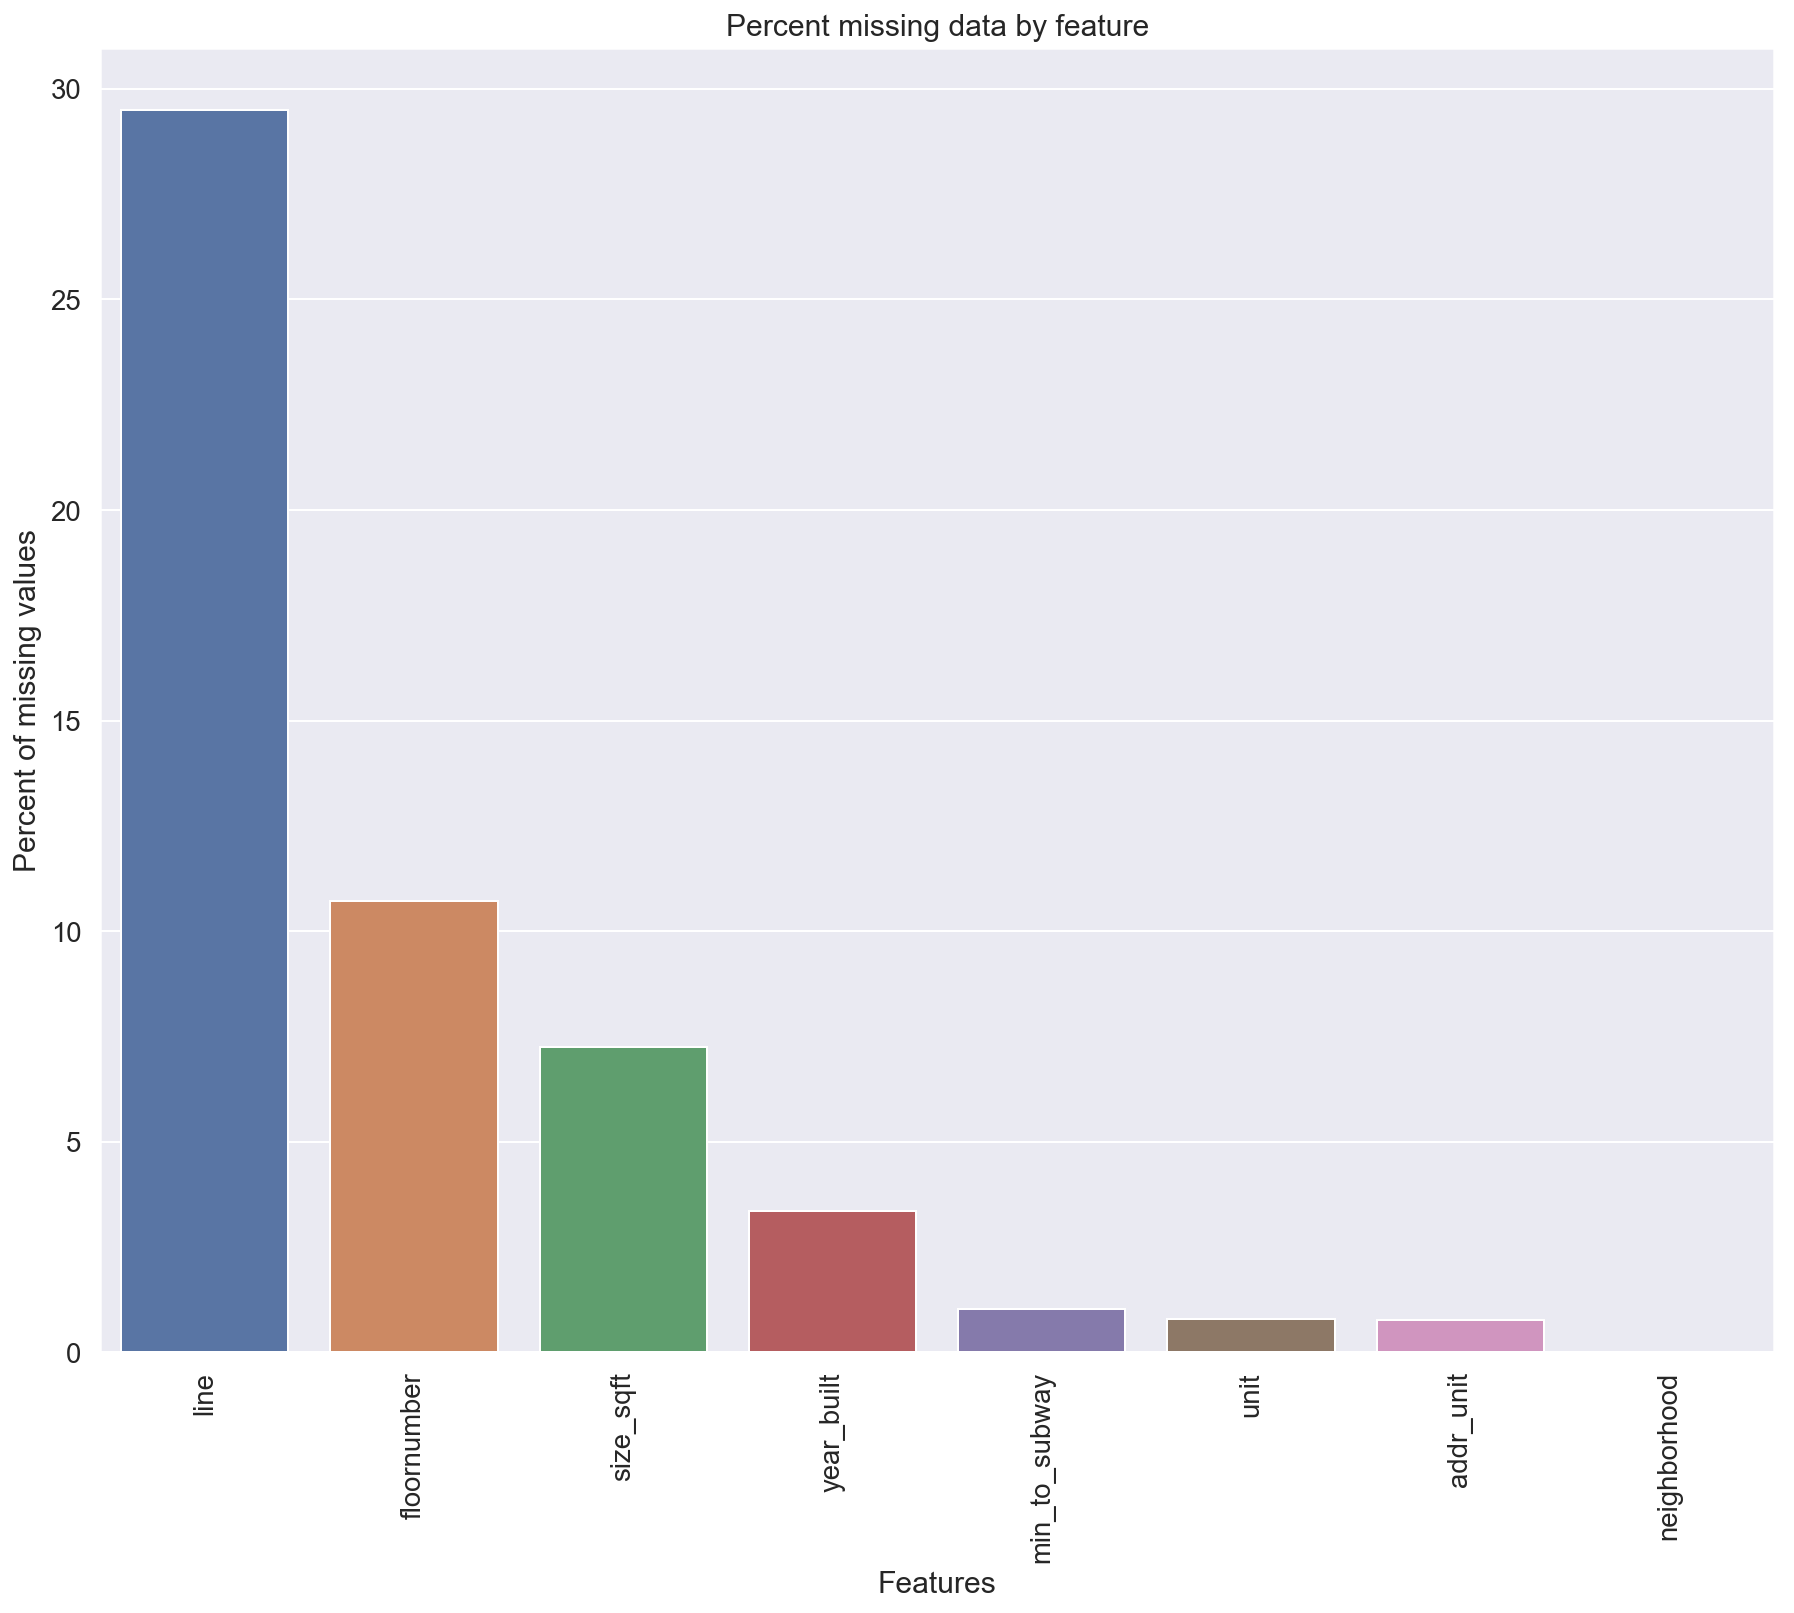

In [ ]:
# Percent missing data by feature

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Lets impute values baded on avg for numeric data and mode for categorical data**

**Every missing column will be imputed with avg composed from groupby objects that seem most appropriate**

- We will impute `line` from other listings close to it, i.e zip code, and __the most occuring value__
- impute `floornumber` with __avg floor number value__ in column and __round to nearest integer__
- impute `size_sqft` with __avg value__ for other listings with __same bedroom size__ as those generally account for how big an apartment is.
- impute `year_built` by the __avg year_built__ of listings in __same zipcode__ 
- impute `min_to_subway` by __avg time to subway__ of other listings in the __same zipcode__
- impute `unit` will __most occuring units__ in unit column
- impute `addr_unit` same as `unit`
- impute missing `neighborhood` with __most occuring neighborhood__ in listing __zip code__


In [ ]:
# impute missing line values using zipcode and most frequent line in that area
all_data_df['line'] = all_data_df.groupby('addr_zip')['line'].transform(lambda x: x.fillna(stats.mode(x).mode[0]))

#impute floornumber missing values with mean floornumber
all_data_df['floornumber'].fillna(all_data_df['floornumber'].mean(),inplace=True)
all_data_df['floornumber'] = all_data_df['floornumber'].round(0).astype(int)

#impute size_sqft missing values with mean size of # of bedrooms
all_data_df['size_sqft'] = all_data_df.groupby('bedrooms')['size_sqft'].transform(lambda x: x.fillna(x.mean()))

#impute year_built missing values with year_built mean of addr_zipcode
all_data_df['year_built'] = all_data_df.groupby('addr_zip')['year_built'].transform(lambda x: x.fillna(x.mean()))

#impute min_to_subway missing values with mean of addr_zipcode
all_data_df['min_to_subway'] = all_data_df.groupby('addr_zip')['min_to_subway'].transform(lambda x: x.fillna(x.mean()))

#left over missing data for min_to_subway, looked online to impute
all_data_df.loc[all_data_df['min_to_subway'].isnull(),'min_to_subway'] = 7  

#impute unit missing values with column mean
all_data_df['unit'].fillna(all_data_df['unit'].mode()[0],inplace=True)

#impute addr_unit missing values with column mean
all_data_df['addr_unit'].fillna(all_data_df['addr_unit'].mode()[0],inplace=True)

#impute neighborhood missing values with addr_zip mode
all_data_df['neighborhood'] = all_data_df.groupby('addr_zip')['neighborhood'].transform(lambda x: x.fillna(stats.mode(x).mode[0]))



Quick check if there are anymore missing values

In [ ]:
#Check if there are any missing values left

all_data_na = (all_data_df.isnull().sum() / len(all_data_df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


## Feature Engineering/ Transformation

- We will encode some categorical features that we feel usually indicate how expensive a home will be in the city

- Based on personal intuition and suggestions from the data, `rent` is dependent on `borough` and Manhattan is known as one of the most expensive places to live.

- Same goes for `addr_zip` and `neighborhood` as certin neighborhoods are known to be more expensive than others and a group of zip codes tend to represent a neighborhood. This is also suggested in the data.

In [ ]:
# feature transoforming borough

print(all_data_df['borough'].describe())

borough_rank_dic = {"Staten Island": 0,
                   "Bronx":1,
                   "Queens":2,
                   "Brooklyn":3,
                   "Manhattan":4}

all_data_df.groupby('borough').count()

all_data_df['borough_encoded'] = all_data_df['borough'].map(borough_rank_dic)

print(borough_rank_dic)


count         13991
unique            5
top       Manhattan
freq           6209
Name: borough, dtype: object
{'Staten Island': 0, 'Bronx': 1, 'Queens': 2, 'Brooklyn': 3, 'Manhattan': 4}


In [ ]:
# feature transforming addr zip

# dictionary for zip_group
zip_group_dic = zip_group.to_dict()

# dictionary with encoded values for zip codes from least to greatest
addr_zip_rank_dic = {key:val for key,val in zip(list(zip_group_dic.keys()),np.arange(0,len(zip_group_dic),1))}

all_data_df['addr_zip_encoded'] = all_data_df['addr_zip'].map(addr_zip_rank_dic)

print(addr_zip_rank_dic)


{10461: 0, 11421: 1, 10452: 2, 10469: 3, 10460: 4, 10468: 5, 10472: 6, 10466: 7, 11369: 8, 10462: 9, 10453: 10, 11423: 11, 10467: 12, 11358: 13, 11417: 14, 11428: 15, 11355: 16, 11435: 17, 11219: 18, 11368: 19, 11212: 20, 10455: 21, 10302: 22, 11691: 23, 11214: 24, 10451: 25, 11693: 26, 10034: 27, 10459: 28, 11414: 29, 11223: 30, 11228: 31, 11415: 32, 11360: 33, 11229: 34, 11434: 35, 11373: 36, 11374: 37, 11209: 38, 11372: 39, 11378: 40, 11210: 41, 10465: 42, 11104: 43, 11377: 44, 11230: 45, 10301: 46, 11370: 47, 11220: 48, 11367: 49, 11379: 50, 11364: 51, 10457: 52, 10458: 53, 11418: 54, 11236: 55, 10040: 56, 11375: 57, 11416: 58, 11361: 59, 11354: 60, 11234: 61, 11103: 62, 11224: 63, 11203: 64, 11218: 65, 11235: 66, 11102: 67, 11226: 68, 11357: 69, 11106: 70, 11105: 71, 11432: 72, 10454: 73, 10037: 74, 10463: 75, 10304: 76, 10471: 77, 10456: 78, 10035: 79, 11208: 80, 10033: 81, 10464: 82, 11365: 83, 11385: 84, 11207: 85, 10032: 86, 10039: 87, 11225: 88, 11213: 89, 11233: 90, 10031: 9

We can see how each zip code is given an encoded value based on their avg rent price, where tribeca has the highest value because it is the most expensive neighborhood

In [ ]:
# feature transforming neighborhoods

print(all_data_df['neighborhood'].describe())

# encode neighborhoods based on their avg values

neighborhood_group_dic = neighborhood_group.to_dict()

# dictionary with encoded values for neighborhoods from least to greatest
neighborhood_rank_dic = {key:val for key,val in zip(list(neighborhood_group_dic.keys()),np.arange(0,
                                                                                                  len(neighborhood_group_dic),
                                                                                                  1))}

all_data_df['neighborhood_encoded'] = all_data_df['neighborhood'].map(neighborhood_rank_dic)
print(neighborhood_rank_dic)

count       13991
unique        151
top       Astoria
freq         1005
Name: neighborhood, dtype: object
{'Pelham Bay': 0, 'Bedford Park': 1, 'Van Nest': 2, 'Highbridge': 3, 'Laconia': 4, 'College Point': 5, 'University Heights': 6, 'Port Morris': 7, 'Castle Hill': 8, 'Wakefield': 9, 'Woodhaven': 10, 'Parkchester': 11, 'St. Albans': 12, 'Grymes Hill': 13, 'Oakland Gardens': 14, 'North Corona': 15, 'Bronxwood': 16, 'Morris Heights': 17, 'East Elmhurst': 18, 'Hollis': 19, 'Edenwald': 20, 'Kingsbridge': 21, 'Norwood': 22, 'Bath Beach': 23, 'Ozone Park': 24, 'Woodstock': 25, 'Queens Village': 26, 'Brownsville': 27, 'Borough Park': 28, 'Corona': 29, 'Marble Hill': 30, 'Briarwood': 31, 'Morris Park': 32, 'Port Richmond': 33, 'Inwood': 34, 'Fordham': 35, 'Howard Beach': 36, 'Morrisania': 37, 'Kensington': 38, 'Midwood': 39, 'Dyker Heights': 40, 'Richmond Hill': 41, 'Elmhurst': 42, 'Kew Gardens': 43, 'Flushing': 44, 'Gravesend': 45, 'Concourse': 46, 'Melrose': 47, 'Rego Park': 48, 'Bay Ridge'

## Merging Datasets

Lets merge all data with our schools data which will list the best school and other stats regarding that school with respect to borough.

In [42]:
merged_all_df = all_data_df.merge(right=schools_df,how='left',on='borough').drop('Unnamed: 0',axis=1)

Let's take a look at the new columns

In [44]:
merged_all_df.head()

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,addr_street,addr_city,addr_zip_x,addr_lat,addr_lon,...,website,grades2018,finalgrades,total_students,graduation_rate,attendance_rate,college_career_rate,addr_zip_y,Latitude,Longitude
0,#22A,551248,4,3.0,1300.0,645 OCEAN AVENUE,Brooklyn,11226,40.646982,-73.960065,...,tywlsbrooklyn.org,6 to 12,6 to 12,406,1.00,0.88,0.97,11206,40.705204,-73.939407
1,#406,3373,0,1.0,475.0,93 WORTH STREET,New York,10013,40.716599,-74.004799,...,hsmse.org,9 to 12,9 to 12,500,0.99,0.96,0.99,10031,40.820740,-73.949097
2,#18A,70747,3,3.0,1886.0,305 EAST 51 STREET,New York,10022,40.755402,-73.967598,...,hsmse.org,9 to 12,9 to 12,500,0.99,0.96,0.99,10031,40.820740,-73.949097
3,#23E,42076,1,1.0,827.0,70 WEST 37TH STREET,New York,10018,40.751301,-73.986298,...,hsmse.org,9 to 12,9 to 12,500,0.99,0.96,0.99,10031,40.820740,-73.949097
4,#3B,319156,3,1.0,1200.0,43 MAC DONOUGH STREET,Brooklyn,11216,40.681132,-73.944678,...,tywlsbrooklyn.org,6 to 12,6 to 12,406,1.00,0.88,0.97,11206,40.705204,-73.939407


## Modeling

- First we will split `all_data` into the oringal train and test sizes

**NOTE**
1. the test set had *some* input in the imputations of missing values but I consider it minimal considering the size of the data set compared to the training set and...

2. most of the columns imputed are not in the final feature list

In [ ]:
# split train and test sets

train = merged_all_df[:ntrain_df]
test = merged_all_df[ntrain_df:]

train.head()

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,addr_street,addr_city,addr_zip_x,addr_lat,addr_lon,...,website,grades2018,finalgrades,total_students,graduation_rate,attendance_rate,college_career_rate,addr_zip_y,Latitude,Longitude
0,#22A,551248,4,3.0,1300.0,645 OCEAN AVENUE,Brooklyn,11226,40.646982,-73.960065,...,tywlsbrooklyn.org,6 to 12,6 to 12,406,1.00,0.88,0.97,11206,40.705204,-73.939407
1,#406,3373,0,1.0,475.0,93 WORTH STREET,New York,10013,40.716599,-74.004799,...,hsmse.org,9 to 12,9 to 12,500,0.99,0.96,0.99,10031,40.820740,-73.949097
2,#18A,70747,3,3.0,1886.0,305 EAST 51 STREET,New York,10022,40.755402,-73.967598,...,hsmse.org,9 to 12,9 to 12,500,0.99,0.96,0.99,10031,40.820740,-73.949097
3,#23E,42076,1,1.0,827.0,70 WEST 37TH STREET,New York,10018,40.751301,-73.986298,...,hsmse.org,9 to 12,9 to 12,500,0.99,0.96,0.99,10031,40.820740,-73.949097
4,#3B,319156,3,1.0,1200.0,43 MAC DONOUGH STREET,Brooklyn,11216,40.681132,-73.944678,...,tywlsbrooklyn.org,6 to 12,6 to 12,406,1.00,0.88,0.97,11206,40.705204,-73.939407


In [ ]:
test.head()

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,addr_street,addr_city,addr_zip_x,addr_lat,addr_lon,...,website,grades2018,finalgrades,total_students,graduation_rate,attendance_rate,college_career_rate,addr_zip_y,Latitude,Longitude
11991,#1B,18724,1,1.0,550.0,167 MOTT STREET,New York,10013,40.719799,-73.996399,...,hsmse.org,9 to 12,9 to 12,500,0.99,0.96,0.99,10031,40.820740,-73.949097
11992,#C4,403900,1,1.0,750.0,107 LINDEN STREET,Brooklyn,11221,40.693118,-73.920035,...,tywlsbrooklyn.org,6 to 12,6 to 12,406,1.00,0.88,0.97,11206,40.705204,-73.939407
11993,#GARDEN,18175264,2,1.0,800.0,47 CARROLL STREET,Brooklyn,11231,40.683399,-74.003998,...,tywlsbrooklyn.org,6 to 12,6 to 12,406,1.00,0.88,0.97,11206,40.705204,-73.939407
11994,#2C,104863,2,2.0,1300.0,952 COLUMBUS AVENUE,New York,10025,40.799900,-73.962799,...,hsmse.org,9 to 12,9 to 12,500,0.99,0.96,0.99,10031,40.820740,-73.949097
11995,#9,95125,2,1.0,750.0,424 EAST 116 STREET,New York,10029,40.795350,-73.934597,...,hsmse.org,9 to 12,9 to 12,500,0.99,0.96,0.99,10031,40.820740,-73.949097


## Creating Models

We will use a linear regressor and a randomforestregressor as the main choices for this round.
We are selecting features based on those *most* correlated with 'rent' from previous analysis and those we encoded.


In [ ]:
###### linear model

features = ['bedrooms','size_sqft','bathrooms','has_washer_dryer','has_doorman','floornumber',
            'has_concierge','has_gym','borough_encoded','addr_zip_encoded',
            'neighborhood_encoded','has_elevator','college_career_rate']

X_train = train[features]
X_test = test[features]

X_train = X_train.fillna(X_train.median(), axis=0)
X_test = X_test.fillna(X_test.median(), axis=0)

lr = LinearRegression()

lr.fit(X_train,target_train)

pred = lr.predict(X_test)

print(f'R2_Score:{lr.score(X_test,target_test)}')

print(f'mean_squared_error:{MSE(target_test,pred)}')


R2_Score:0.6384722974813056
mean_squared_error:2695971.6084931754


**Observations**

- We can see that our R2 score (how accurate our model is) is decent and the MSE is ok, although the test set had some input in imputation for certain features.
- We can see below the coefficient values for the feature variables and see the weights associated with them. Interestingly, bedrooms has a negative coeficient value.

In [ ]:
lr.coef_

array([-2.40933737e+02,  4.06258114e+00,  1.19491496e+03,  1.65014012e+02,
        4.32974453e+01,  2.33843653e+01,  2.13597837e+02,  1.30111387e+02,
        2.66921110e+02,  1.39254839e+01,  4.96183580e+00,  2.98295623e+02,
        1.62155757e+04])

Coefficient help us understand how our target value will change with a single unit increase in a specific predictor variable

### **Random Forest Regressor**

We will create a random forest regressor and see how it compares to the linear model

In [157]:
# random forest ensemble 

rf = RandomForestRegressor()

rf.fit(X_train,target_train)
pred_rf = rf.predict(X_test)

print(f"R2: {rf.score(X_test,target_test)}")

print(f"mean_squared_error: {MSE(target_test,pred_rf)}")


R2: 0.7688822489145204
mean_squared_error: 1723483.1267543766


### Gradient Boosting Regressor

In [ ]:
# Gradient Boosting Ensemble

gb = GradientBoostingRegressor()
gb.fit(X_train,target_train)
pred_gb = gb.predict(X_test)

print(f"R2: {gb.score(X_test,target_test)}")

print(f"mean_squared_error: {MSE(target_test,pred_gb)}")

R2: 0.7664440428760811
mean_squared_error: 1741665.2306692183


Let's look at what features are the main drivers for our algorithm using the feature_importances_ attribute from the randfom forest

In [ ]:
#combining features with their respective importance values

importances = {k:v for (k,v) in zip(features,rf.feature_importances_)}
importances

{'bedrooms': 0.015906435081540743,
 'size_sqft': 0.572824342701454,
 'bathrooms': 0.11149761466045653,
 'has_washer_dryer': 0.008151200491771832,
 'has_doorman': 0.0024826009426942414,
 'floornumber': 0.029540398576669093,
 'has_concierge': 0.004385392886971524,
 'has_gym': 0.007473300840746397,
 'borough_encoded': 0.0019445046574285594,
 'addr_zip_encoded': 0.10942153807754668,
 'neighborhood_encoded': 0.1283719820444664,
 'has_elevator': 0.007297084559631964,
 'college_career_rate': 0.0007036044786221915}

**Observations**

- we can see that size_sqft, bathrooms, addr_zip_encoded, and neighborhood_encoded seem like the main driving features
- We can see that a the ensemble method performed substantially better than the linear regressor...
- Seems like this is our model of choice for now and we need to tune parameters

## **Hyperparameter Tuning**

- We need to tune the random forest regressor in order to see some more improvement in accuracy and MSE scores.

- We will begin by using a randomized search over a wide range of values to narrow down the best values to use in a grid search.

- We use this approach because grid searching is computationally expensive and we will limit the number of combinations we will search with.

In [ ]:
# # random search hyper parameter tuning for random forest regressor before using grid search

# # number of trees in forest
# n_estimators = [int(x) for x in np.linspace(start = 10,stop = 400,num = 30)]

# # maximum depth of each tree
# max_depth = [int(x) for x in np.linspace(start=2,stop=100, num=20)]
# max_depth.append(None)

# # min number of samples required to split on a node
# min_samples_split = [int(x) for x in np.linspace(start=2,stop=50,num=10)]

# # min number of samples per leaf before a split can occur
# min_samples_leaf = [int(x) for x in np.linspace(start=1,stop=100,num=20)]

# # number of features to consider when splitting
# max_features = ['auto','sqrt','log2']

# # if bootstrap sampling is used to train
# bootstrap = [True]

# # final parametr dictionary
# randomf_grid = {'n_estimators':n_estimators,
#                'max_depth':max_depth,
#                'min_samples_split':min_samples_split,
#                'min_samples_leaf':min_samples_leaf,
#                'max_features':max_features,
#                'bootstrap':bootstrap
#                }



**Now that our parameter grid is set we can initialize the *randomizedSearchCv* and train the model with our *X_train* and *target_train* **

In [ ]:
# #intialize estimator

# rfr = RandomForestRegressor()

# # initialize randomized search instance with estimator and parameter dictionary
# rf_search = RandomizedSearchCV(estimator = rfr,param_distributions = randomf_grid,
#                                n_iter=50,n_jobs = -1,cv=10,verbose=2,random_state=42)

# # fit model
# rf_search.fit(X_train,target_train)


**Results**

We see below the best params and a table of the estimators sorted by rank and their params
Using this table we will narrow the grid search params to only the best.

In [ ]:
# # best parameters of the best estimator

# rf_search.best_params_

Now that we see the best parameters for the best, *tuned*, random forest estimator, we can use it to predict on our data and compare it to the *untuned* randomforest

In [ ]:
# # predict using the best estimator
# pred_rrf = rf_search.predict(X_test)

# MSE(target_test,pred_rrf)

Let's look at how well our model is fitting our training data by looking at its R2 score.

In [ ]:
# # R2 score for the randomized search regressor

# rf_search.score(X_test,target_test)

Notice how its fitting our training model about 15% better than our linear model and this is probably due the unlinear nature of some of our variables that aren't captured fully by the linear model.

### Hyper Parameter Tunning for Gradient Boosting Regressor with Randomized Search

In [181]:
# Most of these hyperparameter are similars between RandomTree Forest + Gradient Boosting
n_estimators = [int(x) for x in np.linspace(start = 10,stop = 200,num = 10)]

# maximum depth 
max_depth = [int(x) for x in np.linspace(start=2,stop=70, num=10)]
max_depth.append(None)

# min number of samples required to split on a node
min_samples_split = [int(x) for x in np.linspace(start=2,stop=50,num=10)]

# min number of samples per leaf before a split can occur
min_samples_leaf = [int(x) for x in np.linspace(start=1,stop=70,num=10)]

# number of features to consider when splitting
max_features = ['auto','sqrt','log2']

gbr_grid = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'max_features':max_features,
               }

In [166]:
gbr = GradientBoostingRegressor()

# initialize randomized search instance with estimator and parameter dictionary (50 candiates only)
gbr_search = RandomizedSearchCV(estimator = gbr,param_distributions = gbr_grid,
                               n_iter=50,n_jobs = -1,cv=10,verbose=2,random_state=42)

# fit model
gbr_search.fit(X_train,target_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.4min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_depth': [2, 9, 17, 24, 32, 39, 47, 54, 62, 70, None], 'min_samples_split': [2, 7, 12, 18, 23, 28, 34, 39, 44, 50], 'min_samples_leaf': [1, 8, 16, 24, 31, 39, 47, 54, 62, 70], 'max_features': ['auto', 'sqrt', 'log2']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [167]:
gbr_search.best_params_

pred_gbr = gbr_search.predict(X_test)

MSE(target_test,pred_gbr)

1520892.255470665

### Hyper Parameter Tunning for Gradient Boosting Regressor Using Grid Search

In [188]:
gbr2 = GradientBoostingRegressor()

gbr_grid = {'n_estimators':[10,50,100,200],
               'max_depth':[40,70,90],
               'min_samples_split':[10,34], 
               'min_samples_leaf':[1,11],
               'max_features':['log2','auto'], 
               }

# initialize randomized search instance with estimator and parameter dictionary (50 candiates only)
gbr2_search = GridSearchCV(estimator = gbr2,param_grid = gbr_grid,
                               n_jobs = -1,cv=10,verbose=2)

# fit model
gbr2_search.fit(X_train,target_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 16.7min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 200], 'max_depth': [40, 70, 90], 'min_samples_split': [10, 34], 'min_samples_leaf': [1, 11], 'max_features': ['log2', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [189]:
gbr2_search.best_params_

pred_gbr2 = gbr2_search.predict(X_test)

MSE(target_test,pred_gbr2)

1540509.4867167857

## **Narrowing down our paramter grid**

we will create a dataframe with the results from the randomized search, sorted by their test score, *i.e* *higher score meaning better performace*.


In [ ]:
# dataframe of best values

rf_search_results = pd.DataFrame(rf_search.cv_results_).sort_values(by='rank_test_score').head(15)
rf_search_results


Let's look at the parameters better so that we can narrow down our grid search parameters

We will take the value counts from our previously created dataframe with the top 10 random forest and their parameters

In [ ]:
# better view of parameters

print(f"{rf_search_results['param_n_estimators']} \n")

print(f"{rf_search_results['param_min_samples_split']} \n")

print(f"{rf_search_results['param_min_samples_leaf']}\n")

print(f"{rf_search_results['param_max_features']}\n")

print(f"{rf_search_results['param_max_depth']}\n")

print(f"{rf_search_results['param_bootstrap']}\n")

**Observations**

- The random search helped narrow down parameters to explore further
- The R2 error didnt improve much which is suggesting a ceiling to the improvemnt of the model
- In order to improve the model further we may need to impute using better values/intuitions and testing with other features.

## **Using Grid Search**

We will now use gridsearch to further improve our hyperparameters and thus imporving our models training and predicting capabilities

We will reduce the size of each hyperparameter using only the best results from our randomized search in order to make this process more efficient and less computationally expensive.


In [ ]:
# # grid search to find the optimal hyper parameterss

param_grid = {'n_estimators':[110,180,250],
               'max_depth':[40,70,90],
               'min_samples_split':[10,34], 
               'min_samples_leaf':[1,11],
               'max_features':['log2','auto'], 
               'bootstrap':[True]
               }

# initialize base estimator
rfr_gs = RandomForestRegressor()

# initialize the gridSearchCv with the base random forest and param_grid
grid_search = GridSearchCV(estimator = rfr_gs,param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

# lets fit our model with X_train and target_train
grid_search.fit(X_train,target_train)

let's look at the best_parameters from the best estimator in our grid search

In [ ]:
grid_search.best_params_

Again, lets put result in dataframe and visualize, ranking them with their best test score

We will not extract out the best estimator from the grid search and use it to predict

In [ ]:
best_est = grid_search.best_estimator_


best_pred = best_est.predict(X_test)

print(MSE(target_test,best_pred))

test['rf_pred'] = best_pred

## **Modeling using Transformed Target**

We wil try improving our model by transforming our target like we did previously to make the target variable more normal and reduce skewness and kurtosis

In [ ]:
# transform target variable for better predictions

rf_trans = TransformedTargetRegressor(regressor = best_est,func = np.log1p, inverse_func = np.expm1)
rf_trans.fit(X_train,target_train)
rf_trans_pred = rf_trans.predict(X_test)

MSE(target_test,rf_trans_pred)

In [ ]:
rf_trans.score(X_test,target_test)

In [ ]:
best_est.fit(X_train,target_train)

MSE(target_test,best_est.predict(X_test))

**Observations**

- Notice the the grid search best estimator with the optimal parameters has a better R2 value and MSE score
- The estimator using the transformed target is not as good as the untransformed target. 
- Our model seems to perform okay currently and could be improved on but further development needs to be done.
- seems like we arent going to keep improving substantially with parameter tuning 

## **Gradient Boosting**

we will not use a gradient boosting regressor to try and better our predicting power as this model using gradients to adjust errors to train the next model. 

In [ ]:
# xgb regressor hyperparameters tuning

# learning rate of the model
eta = [x for x in np.linspace(0.0001,0.5,50)]

# min loss reduction to partition on leaf
gamma = [0,10,100,1000,10000]

# max depth of each tree 
xgb_max_depth = [int(x) for x in np.linspace(start=2,stop=70, num=10)]

# min sum weight of all observations in child
min_child_weight = [int(x) for x in np.linspace(1,100,10)]

# number of columns to be sampled from
colsample_bytree = [x for x in np.linspace(0.1,1,5)]

# fraction of observations to be sampled from in each tree
xgb_subsample = [x for x in np.linspace(0.1,1,5)]

# l2 regurlization of terms
xgb_lambda = [int(x) for x in np.linspace(1,100,5)]

# l1 regurlization on weights
alpha = [int(x) for x in np.linspace(1,100,5)]

xgb_params = {
    'eta':eta,
    'gamma':gamma,
    'xgb_max_depth':xgb_max_depth,
    'min_child_weight':min_child_weight,
    'colsample_bytree':colsample_bytree,
    'xgb_subsample':xgb_subsample,
    'xgb_lambda':xgb_lambda,
    'alpha':alpha,
}


In [ ]:
# initialize base estimator
xgbr = xgb.XGBRegressor(seed=42,objective="reg:squarederror")

# random search cv for xgb regressor
random_xgbr = RandomizedSearchCV(estimator = xgbr,param_distributions = xgb_params,
                   n_iter=50,n_jobs = -1,cv=10,verbose=2,random_state=42)

random_xgbr.fit(X_train,target_train)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'eta': [0.0001, 0.01030204081632653, 0.020504081632653062, 0.030706122448979595, 0.04090816326530613, 0.05111020408163266, 0.061312244897959195, 0.07151428571428572, 0.08171632653061225, 0.09191836734693878, 0.10212040816326531, 0.11232244897959184, 0.12252448979591839, 0.132726...: [0.1, 0.325, 0.55, 0.775, 1.0], 'xgb_lambda': [1, 25, 50, 75, 100], 'alpha': [1, 25, 50, 75, 1

In [ ]:
random_xgbr.best_params_

{'xgb_subsample': 0.325,
 'xgb_max_depth': 2,
 'xgb_lambda': 50,
 'min_child_weight': 12,
 'gamma': 100,
 'eta': 0.34696938775510205,
 'colsample_bytree': 1.0,
 'alpha': 50}

In [ ]:
xgbr_best = random_xgbr.best_estimator_

MSE(target_test,xgbr_best.predict(X_test))

In [ ]:
random_xgbr_results = pd.DataFrame(random_xgbr.cv_results_).sort_values(by='rank_test_score').head(10)
random_xgbr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb_subsample,param_xgb_max_depth,param_xgb_lambda,param_min_child_weight,param_gamma,param_eta,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
25,1.225598,0.069572,0.006300,0.000459,0.325,2,50,12,100,0.346969,...,0.906430,0.906382,0.901178,0.907305,0.907052,0.907153,0.908936,0.905812,0.906287,0.001910
34,1.178400,0.061064,0.006401,0.000916,0.775,70,50,23,100,0.44899,...,0.897228,0.894520,0.892302,0.895625,0.895001,0.894705,0.897609,0.895929,0.895189,0.001906
35,1.300201,0.140562,0.008100,0.002772,0.325,24,25,23,100,0.0919184,...,0.897228,0.894520,0.892302,0.895625,0.895001,0.894705,0.897609,0.895929,0.895189,0.001906
13,1.086397,0.065586,0.006399,0.001565,0.55,24,1,12,100,0.387778,...,0.906803,0.902121,0.896506,0.903698,0.905121,0.902273,0.905194,0.904039,0.903383,0.002677
46,1.273300,0.146329,0.008000,0.002444,0.325,47,25,1,10000,0.112322,...,0.912961,0.912322,0.909332,0.915054,0.913675,0.914810,0.914344,0.914221,0.913383,0.001562
27,0.925598,0.049169,0.005901,0.000539,0.55,2,1,12,0,0.010302,...,0.898866,0.891902,0.892562,0.897678,0.899631,0.895078,0.900963,0.896092,0.896992,0.002910
11,1.163898,0.088550,0.007104,0.003832,0.1,70,100,34,1000,0.44899,...,0.886835,0.883141,0.879669,0.884208,0.886524,0.887010,0.886374,0.887388,0.884753,0.002460
20,1.064300,0.105433,0.007302,0.001186,0.55,24,50,34,10,0.163333,...,0.879755,0.874833,0.875503,0.877003,0.875542,0.878513,0.877887,0.879748,0.877029,0.001803
1,0.999898,0.043453,0.005400,0.000663,1,24,100,45,0,0.285757,...,0.875768,0.870241,0.869889,0.873622,0.873668,0.872547,0.877701,0.876040,0.873500,0.002419
9,1.051397,0.113100,0.005901,0.001222,0.325,54,75,45,10000,0.163333,...,0.871882,0.867265,0.868960,0.869763,0.870076,0.872727,0.871916,0.869983,0.870266,0.001509


In [ ]:
# better view of parameters

print(random_xgbr_results['param_xgb_subsample'])

print(random_xgbr_results['param_xgb_max_depth'])

print(random_xgbr_results['param_xgb_lambda'])

print(random_xgbr_results['param_min_child_weight'])

print(random_xgbr_results['param_gamma'])

print(random_xgbr_results['param_eta'])

print(random_xgbr_results['param_colsample_bytree'])

print(random_xgbr_results['param_alpha'])


      

25    0.325
34    0.775
35    0.325
13     0.55
46    0.325
27     0.55
11      0.1
20     0.55
1         1
9     0.325
Name: param_xgb_subsample, dtype: object
25     2
34    70
35    24
13    24
46    47
27     2
11    70
20    24
1     24
9     54
Name: param_xgb_max_depth, dtype: object
25     50
34     50
35     25
13      1
46     25
27      1
11    100
20     50
1     100
9      75
Name: param_xgb_lambda, dtype: object
25    12
34    23
35    23
13    12
46     1
27    12
11    34
20    34
1     45
9     45
Name: param_min_child_weight, dtype: object
25      100
34      100
35      100
13      100
46    10000
27        0
11     1000
20       10
1         0
9     10000
Name: param_gamma, dtype: object
25     0.346969
34      0.44899
35    0.0919184
13     0.387778
46     0.112322
27     0.010302
11      0.44899
20     0.163333
1      0.285757
9      0.163333
Name: param_eta, dtype: object
25        1
34        1
35        1
13    0.775
46    0.775
27     0.55
11        1
20     0

In [ ]:
xgbr_grid_params = {
    'eta':[0.3,0.4,0.5],
    'gamma':[10,100],
    'xgb_max_depth':[400,800],
    'min_child_weight':[12,20],
    'colsample_bytree':[0.8,1],
    'xgb_subsample':[0.1,1],
    'xgb_lambda':[50,75],
    'alpha':[50,75]
}

In [ ]:
# grid search gbr 

grid_search_xgbr = GridSearchCV(estimator = xgbr, param_grid = xgbr_grid_params, 
                           cv = 10, n_jobs = -1, verbose = 2)

grid_search_xgbr.fit(X_train,target_train)

In [ ]:
test['pred']=grid_search_xgbr.best_estimator_.predict(X_test)
test['rent']=target_test
test[['rf_pred','rent','pred']]

In [ ]:

MSE(target_test,test['pred'])

In [ ]:
# import Submission data set


submission_df = pd.read_csv('Datasets/SE_rents2018_test2.csv')

submission_df.head()

We will again drop unnecessary columns and apply the same imputations as the training set

**Note**

- Imputations will solely rely on values attained from itself. I.E the medium will only consist of values from submission set
- This will ensure that there is minimal data leakage and the model has semi unbiased predictions.

In [ ]:
# drop unecessary columns 
submission_df.drop(["rent","created_at",'description','bin'],axis=1,inplace=True)

In [ ]:
# size_sqft = 0 to nan

submission_df.loc[submission_df['size_sqft']==0,'size_sqft'] = np.nan

In [ ]:
# Find NaN Ratio of Dataset

submission_na = (submission_df.isnull().sum() / len(submission_df)) * 100
submission_na = submission_na.drop(submission_na[submission_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio':submission_na})
missing_data

In [ ]:
# Percent missing data by feature

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=submission_na.index, y=submission_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [ ]:
# impute missing line values using zipcode and most frequent line in that area
submission_df['line'] = submission_df.groupby('addr_zip')['line'].transform(lambda x: x.fillna(stats.mode(x).mode[0]))

#impute floornumber missing values with mean floornumber
submission_df['floornumber'].fillna(submission_df['floornumber'].mean(),inplace=True)
submission_df['floornumber'] = submission_df['floornumber'].round(0).astype(int)

#impute size_sqft missing values with mean size of # of bedrooms
submission_df['size_sqft'] = submission_df.groupby('bedrooms')['size_sqft'].transform(lambda x: x.fillna(x.mean()))

#impute year_built missing values with year_built mean of addr_zipcode
submission_df['year_built'] = submission_df.groupby('addr_zip')['year_built'].transform(lambda x: x.fillna(x.mean()))

#impute min_to_subway missing values with mean of addr_zipcode
submission_df['min_to_subway'] = submission_df.groupby('addr_zip')['min_to_subway'].transform(lambda x: x.fillna(x.mean()))

#impute unit missing values with column mean
submission_df['unit'].fillna(submission_df['unit'].mode()[0],inplace=True)

#impute addr_unit missing values with column mean
submission_df['addr_unit'].fillna(submission_df['addr_unit'].mode()[0],inplace=True)

#impute neighborhood missing values with addr_zip mode
submission_df['neighborhood'] = submission_df.groupby('addr_zip')['neighborhood'].transform(lambda x: x.fillna(stats.mode(x).mode[0]))



In [ ]:
#Check if there are any missing values left

submission_na = (submission_df.isnull().sum() / len(submission_df)) * 100
submission_na = submission_na.drop(submission_na[submission_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

We will again seek to encode certain features to make sure that our model can perform optimally. 

We will encode the borough in the same manner as the training set as there are no new entries and, since we dont have rent values, we cant really alter the encoding

In [ ]:
# feature transoforming borough

print(submission_df['borough'].describe())
print(f"\n{submission_df['borough'].value_counts()}")
borough_rank_dic = {"Staten Island": 0,
                   "Bronx":1,
                   "Queens":2,
                   "Brooklyn":3,
                   "Manhattan":4}

submission_df['borough_encoded'] = submission_df['borough'].map(borough_rank_dic)




The same thing will be done with addr_zip in that the values will be imputed using encoded dictionary from the training set.

**Note**

We will have to check for encoded values that are NaN, caused by new zipcodes that arent in our dictionary...

To solve this issue we will impute those values using the avg encoded value for the listing, grouped by borough.
This will provide the avg encoded value for a listing in a borough.

In [ ]:
# feature transforming addr zip

print(submission_df['addr_zip'].describe())

submission_df['addr_zip_encoded'] = submission_df['addr_zip'].map(addr_zip_rank_dic)



In [ ]:
# imputing unknown values in addr_zip_encoded

bor_encoded_avg = submission_df.groupby('borough')['addr_zip_encoded'].mean().round(0).to_dict()

def impute_unknown(rental_id):
    submission_df.loc[submission_df['rental_id'] == rental_id,'addr_zip_encoded'] = bor_encoded_avg[submission_df.loc[submission_df['rental_id'] == rental_id,'borough'].values[0]] 

submission_df[submission_df['addr_zip_encoded'].isnull()]['rental_id'].transform(lambda x: impute_unknown(x))

submission_df[submission_df['addr_zip_encoded'].isnull()]



Finally feature encoding neighborhood will be done similarly to addr_zip using value dictionary from training set..

*Again* note that unknown neighborhoods will get an encoded value that is the avg from neighborhoods in a specific borough

In [ ]:
# feature transforming neighborhoods

print(submission_df['neighborhood'].describe())

submission_df['neighborhood_encoded'] = submission_df['neighborhood'].map(neighborhood_rank_dic)

submission_df[submission_df['neighborhood_encoded'].isnull()]

In [ ]:
# impute unknown neighborhoods

neigh_encoded_avg = submission_df.groupby('borough')['neighborhood_encoded'].mean().round(0).to_dict()

def impute_un(rental_id):
    submission_df.loc[submission_df['rental_id'] == rental_id,'neighborhood_encoded'] = neigh_encoded_avg[submission_df.loc[submission_df['rental_id'] == rental_id,'borough'].values[0]] 
    
submission_df[submission_df['neighborhood_encoded'].isnull()]['rental_id'].transform(lambda x: impute_un(x))

submission_df[submission_df['neighborhood_encoded'].isnull()]


## Predicting using our Model

we will retrain our best_estimator using the train data and test1 data so that the model has more data to train on...

we will combine the test target and train target into a master target for model fitting.


In [ ]:
feature_master =all_data_df[features].fillna(all_data_df[features].median(), axis=0)
target_master = np.concatenate((target_train,target_test))

# grid_search_xgbr.best_estimator_.fit(feature_master,target_master) 

# submission_df['predictions']= grid_search_xgbr.best_estimator_.predict(submission_df[features]) 

## Visualizing 

Looking at the submission data's predictions against our feature variables to see if the predictions *"make sense"* in that there arent any wierd outliers and we could look at the size,bedroom,bathroom, borough, and neighborhood and feel like the values make sense.

In [ ]:
# submission_df[features+['predictions']]

## Exporting File

Lets export our predictions to a csv file for submitting...

we will reindex the data so that rental_id is the index

In [ ]:
# submission_df.set_index('rental_id')[['predictions']].to_csv('prediction_submission2_xgb.csv', header=True)